In [1]:
%%bash
if ! python -c "import quairkit" 2>/dev/null; then
    pip install -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple quairkit 
fi

if ! command -v pdftotext &> /dev/null; then
    conda install -y -c conda-forge poppler
fi

# Brief Introduction to Quantum Computing

<em style="color:gray;">Copyright (c) 2025 QuAIR team. All Rights Reserved.</em>

Quantum computing represents a revolutionary approach to computation that harnesses the principles of quantum mechanics. Unlike classical bits that exist as either 0 or 1, quantum bits (qubits) can exist in superpositions of states, enabling parallel computation. Furthermore, quantum systems can exhibit entanglement - a uniquely quantum phenomenon where each system cannot be described independently of the others, even when separated by large distances. These properties allow quantum computers to solve certain problems exponentially faster than classical computers, with applications in cryptography [2-4], optimization [5-7], chemistry [8-9], and more.

In this tutorial we introduce the basic usage of QuAIRKit. We will cover fundamental concepts in quantum computing, including quantum state representation, quantum evolution(gates, channels and circuit), measurement, and expectation value estimation.

**Table of Contents**

- [Quantum state](#quantum-state)
  - [State Vector](#state-vector)
  - [Density Matrix](#density-matrix)
- [Quantum Evolution](#quantum-evolution)
  - [Quantum Gates](#quantum-gates)
    - [Pauli Gates](#pauil-gates)
    - [Rotation Gates](#rotation-gates)
    - [Two Qubits Gates](#two-qubit-gates)
  - [Quantum Circuit](#quantum-circuit)
  - [Quantum Channel](#quantum-channels)
- [Measurement](#measurement)
  - [Projective Measurement](#projective-measurement)
  - [Positive Operator-Valued Measures](#positive-operator-valued-measurespovms)
- [Expectation](#expectation-value)
  - [Hamiltonian](#hamiltonian)
  - [Expectation Value Estimation](#expectation-value-estimation)

In [2]:
import torch

import quairkit as qkit
from quairkit import Circuit, Hamiltonian
from quairkit.loss import *
from quairkit.operator import *
from quairkit.database import *
from quairkit.qinfo import *

## Quantum State

### State Vector
In classical computing, information is stored in bits that can be either 0 or 1. Quantum computing extends this concept using qubits (quantum bits), which follow the laws of quantum mechanics. Unlike classical bits, qubits can exist in superpositions of states, enabling parallel computation. A single qubit is represented by a **state vector** in a 2D complex vector space. The basis states are:
$$
\ket{0}=
\begin{bmatrix}
1\\
0
\end{bmatrix},\;
\ket{1}=
\begin{bmatrix}
0\\
1
\end{bmatrix}
.
$$
which is known as the **computational basis**.
and any quantum state $\psi$ can be expressed as a linear combination:
$$
\ket{\psi}=\alpha\ket{0}+\beta\ket{1}=
\begin{bmatrix}
\alpha\\
\beta
\end{bmatrix}
.
$$
where $\alpha,\beta\in \Bbb{C}$ are probability amplitudes satisfying the normalization condition:
$$
|\alpha|^2+|\beta|^2=1.
$$

The state can also be parameterized (ignoring global phase) as:
$$
\ket{\psi}=\cos\frac{\theta}{2}\ket{0}+e^{i\phi}\sin\frac{\theta}{2}\ket{1}.
$$
This maps every pure state to a point on the Bloch sphere as Figure. 1 shows, with:
- $\theta$: Polar angle $(0 \leq \theta \leq \pi)$
- $\phi$: Azimuthal angle $(0 \leq \phi < 2\pi)$

<figure style="text-align: center;">
  <img src="figures/qubit_bloch_sphere.png" alt="alt text"/>
  <figcaption>A example of bloch sphere. </figcaption>
</figure>

In QuAIRKit, we can construct a single-qubit quantum state using the following code: 

In [3]:
num_qubits = 1  # set the number of qubits

# create a |0>
state = zero_state(num_qubits)
print(f"Zero state with single qubit: {state}")

# create a |1>
state = one_state(num_qubits)
print(f"One state with single qubit: {state}")

# create a random state
state = random_state(num_qubits)
print(f"Random state with single qubit: {state}")

Zero state with single qubit: 
-----------------------------------------------------
 Backend: default-pure
 System dimension: [2]
 System sequence: [0]
[1.+0.j 0.+0.j]
-----------------------------------------------------

One state with single qubit: 
-----------------------------------------------------
 Backend: default-pure
 System dimension: [2]
 System sequence: [0]
[0.+0.j 1.+0.j]
-----------------------------------------------------

Random state with single qubit: 
-----------------------------------------------------
 Backend: default-mixed
 System dimension: [2]
 System sequence: [0]
[[ 0.98+0.j -0.03+0.j]
 [-0.03-0.j  0.02+0.j]]
-----------------------------------------------------



`State` is a class in QuAIRKit which provides a unified interface for working with both pure and mixed quantum states. It supports two fundamental representations:
- State vectors (for pure states)
  
- Density matrices (for mixed states)

The class handles:

- State initialization and validation

- System dimension management

- State representation conversions

- Common quantum state generation

Check this link for more states you can create: [QuAIRKit.database.state](https://quairkit.com/QuAIRKit/v0.1.0/quairkit.database.state.html#). You can use the functions in this class to construct states like this:

In [4]:
# Create different states
# Index=4 corresponds to |1,1⟩ state
state = computational_state(num_systems=2, index=4, system_dim=[2,3])
print(f'The computationa state is:\n{state}')

state = bell_state(num_systems=2, system_dim=[2,2])
print(f'The Bell state is:\n{state}')

state = ghz_state(num_qubits=3)
print(f'The GHZ-state is:\n{state}')

The computationa state is:

-----------------------------------------------------
 Backend: default-pure
 System dimension: [2, 3]
 System sequence: [0, 1]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
-----------------------------------------------------

The Bell state is:

-----------------------------------------------------
 Backend: default-pure
 System dimension: [2, 2]
 System sequence: [0, 1]
[0.71+0.j 0.  +0.j 0.  +0.j 0.71+0.j]
-----------------------------------------------------

The GHZ-state is:

-----------------------------------------------------
 Backend: default-pure
 System dimension: [2, 2, 2]
 System sequence: [0, 1, 2]
[0.71+0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.71+0.j]
-----------------------------------------------------



Multiple systems can be constructed using tensor product with `nkron` like this

In [5]:
state_1 = zero_state(num_qubits)
state_2 = one_state(num_qubits)
product_state = nkron(state_1, state_2)
print(f"Construct a tensor-product state of individual qubits: {product_state}")

Construct a tensor-product state of individual qubits: 
-----------------------------------------------------
 Backend: default-pure
 System dimension: [2, 2]
 System sequence: [0, 1]
[0.+0.j 1.+0.j 0.+0.j 0.+0.j]
-----------------------------------------------------



### Density Matrix
In quantum mechanics, quantum states can be described equivalently in two mathematical forms:
- State Vector Representation: Used for pure states (Dirac notation $\ket{\psi}$)
- Density Matrix Representation: Used for both pure and mixed states (operator $\rho$)

A pure state represents a quantum system that is fully characterized by a single state vector, while a mixed state describes a statistical mixture of quantum states, representing classical uncertainty about the system's preparation. While state vectors work well for describing pure quantum states, quantum systems often exist as statistical mixtures that require a more general representation. This leads us to the density matrix (or density operator) formalism, which provides a unified framework to describe both pure states and mixed states(statistical ensembles).

For a pure state described by state vector $\ket{\psi}$, the density matrix is $\rho=\ket{\psi}\bra{\psi}$. For a mixed state with probabilities $\{p_i\}$ and states $\{ \ket{\psi_i}\}$, the density matrix is $\rho=\sum_i p_i\ket{\psi_i}\bra{\psi_i}$ with properties:
1. $\rho=\rho^{\dagger}$.
2. $\mathrm{Tr}(\rho)=1$.
3. $\langle\psi\vert\rho\vert\psi\rangle\geq 0$ for all $\ket{\psi}$.

**Example**

Consider a qubit in a mixed state with 50% in $\ket{0}$ and 50% in $\ket{1}$. The density matrix of this mixed state is:
$$
\rho=0.5\ket{0}\bra{0}+0.5\ket{1}\bra{1}=
\begin{pmatrix}
0.5 & 0\\
0 & 0.5
\end{pmatrix}.
$$

In QuAIRKit, we can construct density matrix randomly like this with `random_density_matrix`:

In [6]:
density_matrix = random_density_matrix(num_qubits=2)
print(f"Random density matrix: {density_matrix}")

Random density matrix: tensor([[ 0.1933+0.0000j,  0.1323-0.1586j,  0.1102-0.2323j, -0.1462-0.1607j],
        [ 0.1323+0.1586j,  0.2206+0.0000j,  0.2660-0.0686j,  0.0317-0.2299j],
        [ 0.1102+0.2323j,  0.2660+0.0686j,  0.3420+0.0000j,  0.1098-0.2673j],
        [-0.1462+0.1607j,  0.0317+0.2299j,  0.1098+0.2673j,  0.2441+0.0000j]])


### Quantum Evolution
Quantum state evolution describes how a quantum system changes over time under the laws of quantum mechanics. In closed systems (isolated from the environment), this evolution is:

- Unitary: Preserves the norm of the state vector

- Reversible: The process can theoretically be undone

- Deterministic: For known Hamiltonians, evolution is perfectly predictable

In closed quantum systems (isolated from the environment), quantum evolution is described by unitary operators that preserve the norm of state vectors. Mathematically:
$$
\ket{\psi_{final}}=U\ket{\psi_{init}}.
$$
where $U$ satisfies $U^{\dagger}U=I$. These unitary operators are implemented as quantum gates in quantum circuits.

### Quantum Gates
Quantum gates are the fundamental building blocks of quantum circuits, analogous to classical logic gates (e.g., AND, OR). They are unitary operators that act on qubits, preserving the norm of the quantum state. Mathematically, a quantum gate applied to an $n$-qubit system is represented by a $2^n \times 2^n$ unitary matrix $U$ (i.e., $U^{\dagger}U=I$).

Common quantum gates and their matrix representations are listed below:

#### Pauil Gates
| gate | matrix | code |
|:------:|:--------:|:-----:|
|  X   |$\begin{bmatrix}0 & 1\\1 & 0\end{bmatrix}$| `x` |
|  Y   |$\begin{bmatrix}0 & -i\\i & 0\end{bmatrix}$| `y` |
|  Z   |$\begin{bmatrix}1 & 0\\0 & -1\end{bmatrix}$| `z` |
#### Rotation Gates
Rotation gates implement unitary rotations around Bloch sphere axes by angle $\theta$:
| gate | matrix | code |
|:------:|:--------:|:-----:|
| RX   |$\begin{bmatrix}\cos{\frac{\theta}{2}} & -i\sin{\frac{\theta}{2}} \\ -i\sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}\end{bmatrix}$| `rx` |
| RY   |$\begin{bmatrix}\cos{\frac{\theta}{2}} & -\sin{\frac{\theta}{2}} \\ \sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}\end{bmatrix}$| `ry` |
| RZ   |$\begin{bmatrix}e^{-i\frac{\theta}{2}} & 0 \\ 0 & e^{i\frac{\theta}{2}}\end{bmatrix}$| `rz` |
#### Two-Qubit Gates
| gate | matrix | code |
|:------:|:--------:|:-----:|
| CNOT |$\begin{bmatrix}1 & 0 & 0 & 0\\0 & 1 & 0 & 0\\0 & 0 & 0 & 1\\0 & 0 & 1 & 0\end{bmatrix}$| `cnot` |
| CZ   |$\begin{bmatrix}1 & 0 & 0 & 0\\0 & 1 & 0 & 0\\0 & 0 & 1 & 0\\0 & 0 & 0 & -1\end{bmatrix}$| `cz`|


### Quantum Circuit

Quantum circuits provide the operational framework for quantum computation, translating the abstract principles of unitary evolution into executable sequences of quantum gates.

A quantum circuit is composed of:

- Qubits, represented by horizontal lines (wires).

- Quantum Gates, represented by symbols on the wires, which perform unitary operations.

- Time flows from left to right, defining the order of operations.

By arranging gates in a specific order across qubits, we construct quantum algorithms that exploit superposition and entanglement to solve problems.

Here is a simple demonstration of a quantum circuit:

The unitary matrix of the circuit: tensor([[ 0.0000+0.0000j,  0.0000+0.0000j,  0.5000-0.5000j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j, -0.5000+0.5000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.5000-0.5000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j, -0.5000+0.5000j],
        [ 0.5000-0.5000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         -0.5000+0.5000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.5000-0.5000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j, -0.5000+0.5000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.5000+0.5000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.5000+0.5000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.5000+0.5000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.5000+0.5000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0

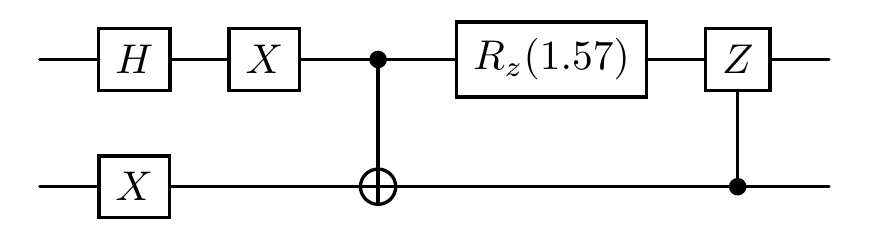

In [7]:
# construct a circuit with specifying the number of qubits
num_qubits = 3  # number of qubits
cir = Circuit(num_qubits)

# add operations
cir.h(0)  # apply Hadamard gate on qubit 0
cir.x([0, 1])  # apply x gate on qubit 0 and 1
cir.cx([0, 1])  # apply cnot gate (control=qubit 0, target=qubit 1) - cx([control, target])
cir.rz(0, param=torch.pi/2)  # apply rz gate on qubit 0 with theta=pi/2
cir.cz([1, 0])  # apply cz gate(control=qubit 1, target=qubit 0) - cz([control, target])

print(f"The unitary matrix of the circuit: {cir.matrix}")
cir.plot()

Alternatively, we can apply the evolution to a specified state (e.g., `cir(state)`) by invoking the circuit object with a given state.

In [8]:
state = random_state(num_qubits=3)
output_state = cir(state)  # apply circuit unitary U to initial state: U|ψ⟩
print(f"The output state for input random state is: {output_state}")

The output state for input random state is: 
-----------------------------------------------------
 Backend: default-mixed
 System dimension: [2, 2, 2]
 System sequence: [1, 0, 2]
[[ 0.13+0.j    0.08+0.1j  -0.01-0.04j  0.01-0.02j  0.01-0.06j  0.03-0.j
  -0.01+0.01j -0.01+0.02j]
 [ 0.08-0.1j   0.15+0.j   -0.05-0.02j  0.01-0.02j -0.05-0.06j -0.03-0.02j
  -0.  -0.01j  0.02+0.02j]
 [-0.01+0.04j -0.05+0.02j  0.09+0.j   -0.04+0.03j  0.04-0.02j -0.01-0.01j
   0.02+0.02j  0.02-0.01j]
 [ 0.01+0.02j  0.01+0.02j -0.04-0.03j  0.08+0.j    0.01+0.03j -0.03+0.02j
  -0.01-0.03j -0.03+0.01j]
 [ 0.01+0.06j -0.05+0.06j  0.04+0.02j  0.01-0.03j  0.16+0.j    0.02-0.07j
   0.01+0.08j -0.03+0.08j]
 [ 0.03+0.j   -0.03+0.02j -0.01+0.01j -0.03-0.02j  0.02+0.07j  0.18+0.j
  -0.04+0.06j -0.09-0.01j]
 [-0.01-0.01j -0.  +0.01j  0.02-0.02j -0.01+0.03j  0.01-0.08j -0.04-0.06j
   0.1 +0.j    0.04+0.05j]
 [-0.01-0.02j  0.02-0.02j  0.02+0.01j -0.03-0.01j -0.03-0.08j -0.09+0.01j
   0.04-0.05j  0.12+0.j  ]]
---------------

**Example**

To better observe the evolution of the quantum state, let's create a quantum circuit to simulate the process and analyze the results at each step through a step-by-step derivation. We can use `Circuit` to create a quantum circuit as shown below, add quantum gates through gate functions like `h`, `cx`, `rz`, and finally perform a default evolution on the $\ket{0}$ state by directly calling the created circuit object (e.g., `cir()`):

In [9]:
# construct a circuit with specifying the number of qubits
num_qubits = 1  # number of qubits
cir = Circuit(num_qubits)

Let us now observe the evolutionary process described by the above circuit step by step through mathematical derivation. Start with the ground state:
$$ \ket{\psi_0}=\ket{0}=
\begin{bmatrix}
1\\
0
\end{bmatrix}.
$$
**Step 1**: Hadamard Gate($H$)

Add H gate on $\psi_0$ to create superposition:
$$
\ket{\psi_1} = H\ket{0}=\frac{\ket{0}+\ket{1}}{\sqrt{2}}=\frac{1}{\sqrt{2}}
\begin{bmatrix}
1\\
1
\end{bmatrix}.
$$

In [10]:
cir.h(0)  # add Hadamard gate on qubit 0
print(f"The unitary matrix of the circuit after H gate: \n{cir.matrix}")

The unitary matrix of the circuit after H gate: 
tensor([[ 0.7071+0.j,  0.7071+0.j],
        [ 0.7071+0.j, -0.7071+0.j]])


**Step 2**: Phase Rotation($RZ$)

Add relative phase $\theta=\pi/2$:
$$
\ket{\psi_2}=RZ(\frac{\pi}{2})\ket{\psi_1}=\frac{e^{-i\pi/4}\ket{0}+e^{i\pi/4}\ket{1}}{\sqrt{2}}=\frac{1}{\sqrt{2}}
\begin{bmatrix}
e^{-i\pi/4}\\
e^{i\pi/4}
\end{bmatrix}.
$$


In [11]:
cir.rz(0, torch.pi/2)  # add CZ gate on qubit 0 with θ=π/2
print(f"The unitary matrix of the circuit after H gate and CZ gate: \n{cir.matrix}")

The unitary matrix of the circuit after H gate and CZ gate: 
tensor([[ 0.5000-0.5000j,  0.5000-0.5000j],
        [ 0.5000+0.5000j, -0.5000-0.5000j]])


Due to Euler's Formula $e^{i\theta}=\cos(\theta)+i\sin(\theta)$, we can obtain:
$$
e^{-i\pi/4}=\cos(\pi/4)-i\sin(\pi/4)=\frac{1-i}{\sqrt{2}}.
$$
$$
e^{i\pi/4}=\cos(\pi/4)+i\sin(\pi/4)=\frac{1+i}{\sqrt{2}}.
$$
the above expression of $\ket{\psi_2}$ is equivalent to:
$$
\ket{\psi_2}=\frac{1}{\sqrt{2}}
\begin{bmatrix}
e^{-i\pi/4}\\
e^{i\pi/4}
\end{bmatrix}=
\frac{1}{\sqrt{2}}
\begin{bmatrix}
\frac{1-i}{\sqrt{2}}\\
\frac{1+i}{\sqrt{2}}
\end{bmatrix}=
\frac{1}{2}
\begin{bmatrix}
1-i\\
1+i
\end{bmatrix}=
\begin{bmatrix}
0.5-0.5i\\
0.5+0.5i
\end{bmatrix}.
$$
This is consistent with the results obtained from the code.

In [12]:
print(f"The unitary matrix of the final circuit: \n{cir.matrix}")

output_state = cir()  # run the circuit with initial state |0>
print(f"\nThe output state for inputting zero state is: {output_state}")

The unitary matrix of the final circuit: 
tensor([[ 0.5000-0.5000j,  0.5000-0.5000j],
        [ 0.5000+0.5000j, -0.5000-0.5000j]])

The output state for inputting zero state is: 
-----------------------------------------------------
 Backend: default-pure
 System dimension: [2]
 System sequence: [0]
[0.5-0.5j 0.5+0.5j]
-----------------------------------------------------



#### Quantum Channels

Quantum channels are completely positive, trace-preserving (CPTP) maps that describe the most general physical transformations of quantum states. Unlike unitary gates, they can model:
- Noise processes (decoherence, amplitude damping)
  
- Measurement effects
  
- Open system dynamics (interaction with environment)

A key feature of a quantum channel is its ability to transform a pure state into a mixed state, described by a density matrix with non-zero entropy. While they can be represented in several mathematically equivalent ways (Kraus, Choi, Stinespring representations), in practice, we often define them by their action on qubits. Here we only introduce the Kraus representation. You can find more representations at [QuAIRKit Tutorial](https://quairkit.com/QuAIRKit/latest/tutorials/introduction/operator.html). A common example is the Depolarizing Channel, which with probability $p$ randomly applies an X, Y, or Z error to a qubit, and with probability $(1-p)$ leaves it untouched.

**Kraus Representation**

Mathematically, a quantum channel $\mathcal{N}$ acts on density matrix $\rho$ as:
$$
\mathcal{N}(\rho)=\sum_i K_i \rho K_i^{\dagger}.
$$
where Kraus operators $\{ K_i\}$ satisfy:
$$
\sum_i K_i^{\dagger} K_i = I.
$$

### Common Quantum Channel Examples
**Depolarizing Channel**

The depolarizing channel is a fundamental noise model in quantum information theory. It describes a process where, with a certain probability, the quantum state is replaced by the completely mixed state, effectively introducing isotropic noise (noise that is the same in all directions).

The action of the depolarizing channel on a density matrix $\rho$ with probability $p$ is given by:
$$
\Phi_{depo}(\rho)=(1-p)\rho + p\frac{I}{d}.
$$
where:
- $p$: The error probability or depolarizing probability. It is a real number between 0 and 1 ($0 \leq p \leq 1$).
- $d$: The dimension of the Hilbert space of the quantum system.
- $I$: The identity operator (or identity matrix) acting on the Hilbert space of the quantum system. Its dimension matches that of $\rho$.

The Kraus representation for the depolarizing channel can be expressed in terms of the identity operator and Pauli matrices. For a single qubit (d=2), the Kraus operators are:
$$
K_0 = \sqrt{1-\frac{3p}{4}}I, \quad K_1 = \sqrt{\frac{p}{4}}X, \quad K_2 = \sqrt{\frac{p}{4}}Y, \quad K_3 = \sqrt{\frac{p}{4}}Z.
$$
where $X,Y,Z$ are the Pauli matrices and $I$ is the identity matrix.

Depolarizing Channel can be easily constructed using `depolarizing_kraus` in kraus representation:

In [13]:
probs = 0.5 # probability
depolarizing_kraus_repr = depolarizing_kraus(probs) # Kraus representation

print(f"Kraus representation of a depolarizing channel with probability {probs}:\n {depolarizing_kraus_repr}\n")

Kraus representation of a depolarizing channel with probability 0.5:
 tensor([[[ 0.7906+0.0000j,  0.0000+0.0000j],
         [ 0.0000+0.0000j,  0.7906+0.0000j]],

        [[ 0.0000+0.0000j,  0.3536+0.0000j],
         [ 0.3536+0.0000j,  0.0000+0.0000j]],

        [[ 0.0000+0.0000j,  0.0000-0.3536j],
         [ 0.0000+0.3536j,  0.0000+0.0000j]],

        [[ 0.3536+0.0000j,  0.0000+0.0000j],
         [ 0.0000+0.0000j, -0.3536+0.0000j]]])



**Amplitude Damping (AD) Channel** 

The amplitude damping channel is the channel given with Kraus operators:
$$
K_0=
\begin{bmatrix}
1 & 0\\
0 & \sqrt{1-\gamma}
\end{bmatrix},\;
K_1=
\begin{bmatrix}
0 & \sqrt{\gamma}\\
0 & 0
\end{bmatrix}.
$$
where $\gamma\in[0,1]$.

AD channel can be constructed using `amplitude_damping_kraus` in kraus representation:

In [14]:
gamma = 0.5 # parameter gamma
amplitude_damping_kraus_repr = amplitude_damping_kraus(gamma) # Kraus representation

print(f"Kraus representation of a amplitude damping channel with parameter {gamma}:\n {amplitude_damping_kraus_repr}\n")

Kraus representation of a amplitude damping channel with parameter 0.5:
 tensor([[[1.0000+0.j, 0.0000+0.j],
         [0.0000+0.j, 0.7071+0.j]],

        [[0.0000+0.j, 0.7071+0.j],
         [0.0000+0.j, 0.0000+0.j]]])



And we can add channels to circuit like this:

In [15]:
# Similarly, you can implement custom channels using Circuit.append.
kraus_op = random_channel(num_systems=1, target="kraus")
cir.kraus_channel(kraus_op, system_idx=0)

**Example**

To understand how quantum channels work in practice, let's examine a concrete example using the Kraus representation. We will create two common noise channels—depolarizing and amplitude damping—see their Kraus operators, and most importantly, observe how they transform a pure state into a mixed state.

**Step 1**: Initial Pure State Preparation

We begin with the computational basis state $\ket{0}$, which will serve as our input to the quantum channels.

In [16]:
# Example: Demonstrating Kraus representation and pure-to-mixed state transformation

# Define parameters for the channels
depolarizing_prob = 0.7  # Strong depolarizing probability
damping_gamma = 0.3      # Amplitude damping parameter

# --- 1. Create a pure state |0⟩ ---
print("1. CREATING INITIAL PURE STATE")
init_state = zero_state(num_qubits=1)  # |0⟩ state
print(f"Initial state: {init_state}")
print(f"State vector: {init_state}")

1. CREATING INITIAL PURE STATE
Initial state: 
-----------------------------------------------------
 Backend: default-pure
 System dimension: [2]
 System sequence: [0]
[1.+0.j 0.+0.j]
-----------------------------------------------------

State vector: 
-----------------------------------------------------
 Backend: default-pure
 System dimension: [2]
 System sequence: [0]
[1.+0.j 0.+0.j]
-----------------------------------------------------



**Step 2**: Depolarizing Channel Implementation

Applying the depolarizing channel with probability p=0.7 to our initial state. The transformation follows:
$$
\Phi_{depo}(\rho)=(1-0.7)\ket{0}\bra{0} + 0.7·\frac{I}{2}=0.3\ket{0}\bra{0}+0.35I.
$$
The corresponding Kraus operators with numerical coefficients:
$$
K_0 = \sqrt{0.475}I \approx 0.689I.
$$
$$
K_1 = \sqrt{0.175}X \approx 0.418X.
$$
$$
K_2 = \sqrt{0.175}Y \approx 0.418Y.
$$
$$
K_3 = \sqrt{0.175}Z \approx 0.418Z.
$$
We extract and examine the Kraus operators that implement this transformation.

In [17]:
# --- 2. Depolarizing Channel Example ---
print("2. DEPOLARIZING CHANNEL:")

# Get Kraus operators for depolarizing channel
depolarizing_kraus_ops = depolarizing_kraus(depolarizing_prob)
print(f"Kraus operators (p={depolarizing_prob}):")
for i, op in enumerate(depolarizing_kraus_ops):
    print(f"K{i}:\n{op}")

# Apply channel to pure state
depolarized_state = init_state.transform(depolarizing_kraus_ops, sys_idx=[0])
print(f"\nAfter depolarizing channel, the output state:{depolarized_state}")

2. DEPOLARIZING CHANNEL:
Kraus operators (p=0.7):
K0:
tensor([[0.6892+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.6892+0.j]])
K1:
tensor([[0.0000+0.j, 0.4183+0.j],
        [0.4183+0.j, 0.0000+0.j]])
K2:
tensor([[0.+0.0000j, 0.-0.4183j],
        [0.+0.4183j, 0.+0.0000j]])
K3:
tensor([[ 0.4183+0.j,  0.0000+0.j],
        [ 0.0000+0.j, -0.4183+0.j]])

After depolarizing channel, the output state:
-----------------------------------------------------
 Backend: default-mixed
 System dimension: [2]
 System sequence: [0]
[[0.65+0.j 0.  +0.j]
 [0.  +0.j 0.35+0.j]]
-----------------------------------------------------



**Step 3**: Amplitude Damping Channel Implementation

Now applying amplitude damping with $\gamma=0.3$. The Kraus operators implement:
$$
K_0=\ket{0}\bra{0}+\sqrt{0.7}\ket{1}\bra{1} \approx \ket{0}\bra{0}+0.837\ket{1}\bra{1}.
$$
$$
K_1=\sqrt{0.3}\ket{0}\bra{1} \approx 0.548 \ket{0}\bra{1}.
$$
The output state becomes:
$$
\rho_{out} = K_0 \ket{0}\bra{0}K^{\dagger}_0+K_1\ket{0}\bra{0}K^{\dagger}_1=\ket{0}\bra{0}+0.3\ket{0}\bra{0}=\ket{0}\bra{0}.
$$

In [18]:
# --- 3. Amplitude Damping Channel Example ---
print("3. AMPLITUDE DAMPING CHANNEL:") 

# Get Kraus operators for amplitude damping
damping_kraus_ops = amplitude_damping_kraus(damping_gamma)
print(f"Kraus operators (γ={damping_gamma}):")
for i, op in enumerate(damping_kraus_ops):
    print(f"K{i}:\n{op}")

# Apply channel to pure state
damped_state = init_state.transform(damping_kraus_ops, sys_idx=[0])
print(f"\nAfter amplitude damping channel, the output state:{damped_state}")

3. AMPLITUDE DAMPING CHANNEL:
Kraus operators (γ=0.3):
K0:
tensor([[1.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.8367+0.j]])
K1:
tensor([[0.0000+0.j, 0.5477+0.j],
        [0.0000+0.j, 0.0000+0.j]])

After amplitude damping channel, the output state:
-----------------------------------------------------
 Backend: default-mixed
 System dimension: [2]
 System sequence: [0]
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
-----------------------------------------------------



## Measurement

Quantum measurement is the process of extracting classical information from a quantum system, causing the system's state to collapse probabilistically to an eigenstate of the measured observable. Unlike classical measurements, quantum measurements:

- Are fundamentally probabilistic

- Irreversibly alter the quantum state (wavefunction collapse)

- Depend on the choice of measurement basis

### Projective Measurement

An observable $O$ is represented by a Hermitian operator ($O=O^{\dagger}$). Being Hermitian, it admits a spectral decomposition into its eigenvalues $\lambda_i$ (the possible measurement outcomes) and corresponding orthonormal eigenstates $\ket{\sigma_i}$:
$$
O=\sum_i \lambda_i \ket{\sigma_i}\bra{\sigma_i}.
$$

**Born Rule**



For a quantum system in a pure state $\ket{\psi}$, Upon measurement of $O$ the system yields an outcome associated with eigenvalue $\lambda_i$, occurring with probability:

$$
p_i=|\langle \sigma_i \vert \psi \rangle|^2.
$$
Following the measurement, the post-measurement state collapses to the corresponding eigenstate:
$$
\ket{\psi}\xrightarrow{\text{after measure}}\ket{\sigma_i}.
$$

### Positive Operator-Valued Measures
A more general Positive Operator-Valued Measure (POVM) is a set of operators ${E_i}$ where:
$$
E_i=M_i^{\dagger}M_i,\quad \sum_i E_i=I.
$$
the probability of outcome $i$ is:
$$
p_i= \mathrm{Tr} (M_i \rho M_i^{\dagger})= \mathrm{Tr} (E_i \rho).
$$
Unlike projective measurements, POVMs allow non-orthogonal measurements.

In [19]:
# Construct a POVM for the single-qubit Pauli-X basis
pvm = pauli_str_povm("x")
print(f"Projection-valued measure: \n{pvm}")
op = Measure(pvm)
state = random_state(num_qubits=2, rank=2)

# Measure on qubit 0 and keep the collapsed state
prob, collapsed_state = op(state, qubits_idx=[0], keep_state=True)
print(f"\nThe collapsed state for each outcome is: {collapsed_state}")

Projection-valued measure: 
tensor([[[ 0.5000+0.j,  0.5000+0.j],
         [ 0.5000+0.j,  0.5000+0.j]],

        [[ 0.5000+0.j, -0.5000+0.j],
         [-0.5000+0.j,  0.5000+0.j]]])

The collapsed state for each outcome is: 
-----------------------------------------------------
 Backend: default-mixed
 System dimension: [2, 2]
 System sequence: [0, 1]
 Batch size: [2]

 # 0:
[[ 0.32+0.j   -0.12+0.13j  0.32+0.j   -0.12+0.13j]
 [-0.12-0.13j  0.18+0.j   -0.12-0.13j  0.18+0.j  ]
 [ 0.32+0.j   -0.12+0.13j  0.32+0.j   -0.12+0.13j]
 [-0.12-0.13j  0.18+0.j   -0.12-0.13j  0.18+0.j  ]]
 # 1:
[[ 0.34+0.j    0.11+0.11j -0.34+0.j   -0.11-0.11j]
 [ 0.11-0.11j  0.16+0.j   -0.11+0.11j -0.16+0.j  ]
 [-0.34+0.j   -0.11-0.11j  0.34+0.j    0.11+0.11j]
 [-0.11+0.11j -0.16+0.j    0.11-0.11j  0.16+0.j  ]]
-----------------------------------------------------



With this general framework in place, we now turn to the most important observable in most quantum systems: the Hamiltonian.
### Hamiltonian 
Among all quantum observables, the Hamiltonian operator holds a place of paramount importance. Its expectation value has a direct and profound physical interpretation: it represents the average energy of the quantum system in the state $\ket{\psi}$. For this reason, calculating it is a central task in many quantum problems, from analyzing molecular structures to optimizing quantum algorithms.

In quantum mechanics, a Hamiltonian ($\mathcal{H}$) is a Hermitian operator that corresponds to the total energy of a quantum system. It governs the time evolution of quantum states through the Schrödinger equation. For quantum computing purposes, we typically work with time-independent Hamiltonians expressed as sums of Pauli operators:
$$
H = \sum_i c_i h_i.
$$
where $h_i$ are Pauli strings (e.g., $h_i \in \{I,X,Y,Z\}^{\otimes n}$ for $n$ qubit system) and $c_i$ are real coefficients. 

**Building Quantum Hamiltonians**

A quantum Hamiltonian characterizes the interactions among the constituents of a quantum system. To facilitate simulations, the library implements several convenient routines for building Hamiltonians of common models.

**Example 1**: Ising-type Model

The Ising model is one of the simplest yet most important models that describes interacting quantum bits (qubits). It plays a central role in quantum optimization and quantum simulation, providing a minimal framework to study collective quantum phenomena.

This model captures two essential physical effects:
- Qubit interactions: Qubits influence each other through ZZ coupling terms.

- External influence: Individual qubits are affected by external fields (X terms).

Formally, for $n$ qubit system, Ising model describes Hamiltonian with two-site interaction and external field:
$$ 
H_{\text{Ising}} = \sum_{i<j} J_{ij}Z_i Z_j + \sum_{k} h_k X_k 
$$ 
where $J_{ij}$ is the coupling strength between sites $i$ and $j$, and $h_k$ is the magnetic field strength at vertex $k$. In QuAirKit, Ising model can be constructed via ising_hamiltonian.

In QuAirKit, the Ising Hamiltonian can be readily constructed using the function ``ising_hamiltonian``.

In [20]:
# Hamiltonian construction examples
num_qubits = 3  # initial setting with 3 qubits
split_line = '\n' + '-' * 100 + '\n'

# J matrix controls qubit-qubit interaction strengths
# h vector controls external field strengths on each qubit
J = torch.ones(num_qubits, num_qubits) * 0.5  # uniform interaction strength
h = torch.ones(num_qubits) * 0.3  # uniform external field
H = ising_hamiltonian(J, h)
print("The Pauli decomposition of the Hamiltonian for the Ising model is:\n", H, end=split_line)

The Pauli decomposition of the Hamiltonian for the Ising model is:
 0.5 Z0, Z1
0.5 Z0, Z2
0.5 Z1, Z2
0.30000001192092896 X0
0.30000001192092896 X1
0.30000001192092896 X2
----------------------------------------------------------------------------------------------------


**Other Hamiltonian**

The hamiltonian library supports various interaction patterns. Here are additional examples (For further details regarding Hamiltonian, please refer to the dedicated tutorial:
[Hamiltonian](https://github.com/QuAIR/QuAIRKit/blob/main/tutorials/introduction/Hamiltonian.ipynb)):

In [21]:
# Hamiltonian with XX and YY interactions (XY model)
gamma = torch.ones(2, num_qubits, num_qubits) * 0.5
H = xy_hamiltonian(gamma)
print("The Pauli decomposition of the Hamiltonian for the XY chain is:\n", H, end=split_line)

# Hamiltonian with full XYZ interactions (Heisenberg model)
gamma = torch.ones(3, num_qubits, num_qubits) * 0.5
H = heisenberg_hamiltonian(gamma)
print("The Pauli decomposition of the Hamiltonian for the Heisenberg model is:\n", H, end=split_line)

# Random Hamiltonian for general use
H = random_hamiltonian_generator(num_qubits)
print("The Pauli decomposition of the random Hamiltonian is:\n", H, end=split_line)

# Custom Hamiltonian from explicit coefficients
h_list = [[0.1, "X0,Z1"], [0.3, "Z1"], [0.5, "Z2"]]  # [coefficient, Pauli_string]
H_custom = Hamiltonian(h_list)
print("Custom Hamiltonian from coefficient list:\n", H_custom)

The Pauli decomposition of the Hamiltonian for the XY chain is:
 0.5 X0, X1
0.5 Y0, Y1
0.5 X0, X2
0.5 Y0, Y2
0.5 X1, X2
0.5 Y1, Y2
----------------------------------------------------------------------------------------------------
The Pauli decomposition of the Hamiltonian for the Heisenberg model is:
 0.5 X0, X1
0.5 Y0, Y1
0.5 Z0, Z1
0.5 X0, X2
0.5 Y0, Y2
0.5 Z0, Z2
0.5 X1, X2
0.5 Y1, Y2
0.5 Z1, Z2
----------------------------------------------------------------------------------------------------
The Pauli decomposition of the random Hamiltonian is:
 0.45403777068681817 Y0, X1
-0.270132904940946 X0
0.9207009676070583 Y1, Z2
----------------------------------------------------------------------------------------------------
Custom Hamiltonian from coefficient list:
 0.1 X0, Z1
0.3 Z1
0.5 Z2


The expectation value of an observable $O$, which is the hamiltonian matrix, in quantum represents the statistical average of measurement outcomes obtained from repeated experiments on identically prepared systems. 

For a pure state $|\psi \rangle$, the expectation value is defined as:
$$
\langle O \rangle=\langle \psi \vert O \vert \psi \rangle.
$$
For a mixed state described by a density matrix $\rho$, the expectation value is defined as:
$$
\langle O \rangle = \mathrm{Tr}(O\rho).
$$

The observable $O$ can be decomposed by the spectral decomposition 
$$
\langle O \rangle=\sum_i \lambda_i |\sigma_i\rangle\langle \sigma_i|.
$$
where $\lambda_i$ is eigenvalue of the observable $O$ and  $|\sigma_i\rangle\langle \sigma_i|$ is an corresponding to eigenvector. Then, the expectation value may be rewritten by:
$$
\langle O \rangle=\sum_i \lambda_i \,p_i.
$$
where $p_i= \mathrm{Tr}(\rho |\sigma_i\rangle\langle \sigma_i|)$ for arbitrary state $\rho$ is the probability of obtaining the outcome $|\sigma_i\rangle$.

The `expec_val` may be employed to compute the expectation value for a specified Hamiltonian and quantum state.

In [22]:
# caculate the expection value
H = random_hamiltonian_generator(num_qubits)
print("The Pauli decomposition of the random Hamiltonian is:\n", H, end=split_line)
rho = random_state(num_qubits=3)
print(f"random state with three qubit: {rho}")
print(f"Expection value of the Hamiltonian: {rho.expec_val(H)}")

The Pauli decomposition of the random Hamiltonian is:
 0.8501514511256654 Z0, Y1, X2
0.9491868763526996 X2
-0.19439967249921986 X0, Z1, X2
----------------------------------------------------------------------------------------------------
random state with three qubit: 
-----------------------------------------------------
 Backend: default-mixed
 System dimension: [2, 2, 2]
 System sequence: [0, 1, 2]
[[ 0.07+0.j    0.01+0.04j  0.02+0.06j  0.01+0.01j  0.04-0.07j  0.  -0.03j
  -0.  -0.01j -0.03-0.01j]
 [ 0.01-0.04j  0.32+0.j    0.1 -0.03j  0.02-0.04j -0.01-0.13j -0.01-0.07j
  -0.11-0.01j -0.04+0.03j]
 [ 0.02-0.06j  0.1 +0.03j  0.1 -0.j    0.03-0.02j -0.04-0.07j -0.03-0.05j
  -0.04-0.04j -0.01+0.02j]
 [ 0.01-0.01j  0.02+0.04j  0.03+0.02j  0.06+0.j   -0.  +0.01j -0.02-0.04j
  -0.02-0.03j -0.06+0.02j]
 [ 0.04+0.07j -0.01+0.13j -0.04+0.07j -0.  -0.01j  0.15-0.j    0.05+0.j
   0.01-0.03j -0.01-0.01j]
 [ 0.  +0.03j -0.01+0.07j -0.03+0.05j -0.02+0.04j  0.05-0.j    0.09-0.j
   0.05-0.04j  0.0

This tutorial has introduced the core functionalities of QuAIRKit, demonstrating its capabilities for quantum state manipulation, gate operations, measurements, and expectation value estimation—essential tools for quantum algorithm development and simulation.

---

## References

[1] Nielsen, Michael A., and Isaac L. Chuang. Quantum computation and quantum information. Cambridge university press, 2010.

[2] Shor, Peter W. "Algorithms for quantum computation: discrete logarithms and factoring." Proceedings 35th annual symposium on foundations of computer science. Ieee, 1994.

[3] Gisin, Nicolas, et al. "Quantum cryptography." Reviews of modern physics 74.1 (2002): 145.

[4] Bennett, Charles H., and Gilles Brassard. "Quantum cryptography: Public key distribution and coin tossing." Theoretical computer science 560 (2014): 7-11.

[5] Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).

[6] Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." Nature communications 5.1 (2014): 4213.

[7] Tilly, Jules, et al. "The variational quantum eigensolver: a review of methods and best practices." Physics Reports 986 (2022): 1-128.

[8] Levine, Ira N., Daryle H. Busch, and Harrison Shull. Quantum chemistry. Vol. 6. Upper Saddle River, NJ: Pearson Prentice Hall, 2009.

[9] Cao, Yudong, et al. "Quantum chemistry in the age of quantum computing." Chemical reviews 119.19 (2019): 10856-10915.

*Table: A reference of notation conventions in this tutorial.*

| Symbol        | Variant          | Description                               |
|:---------------:|:------------------:|-------------------------------------------|
| $\ket{\psi}$ |  | State vector representation of quantum states |
| $\rho$ |  | Density matrix representation of quantum states|
| $U$ |  | Unitary operations|
| $H,X,Y,Z$ |  | Hadamard gate and Pauli matrices|
| $M$ |  | Quantum measurement operator|
| $p$ | $p_i$ | THe probability|
| $K_i$ |  | Kraus operators for quantum channels|
| $\mathcal{N}$ |$\Phi, \Phi_{depo} ,\Phi_{AD}$ | Quantum channel (CPTP map)|
| $H$ | $H_{\text{Ising}}$ | Hamiltonian operator|
| $O$ |  | Observable operator|
| $\lambda_i$ | | Set of eigenvalues of observable $O$|
| $\langle O \rangle$ |  | Expectation value of observable $O$ in state $\ket{\psi}$|
| $\alpha,\beta$ |  | Probability amplitudes in quantum superposition|
| $\theta, \phi$ |  | Angles parameterizing quantum states on Bloch sphere|
| $I$ | $I_d$ | Identity operator of dimension $d$ |
| $\mathrm{Tr}$ |  | Trace operation|
| $\mathrm{Tr}_B$ |  | Partial trace over subsystem B|
| $\dagger$ | | Hermitian conjugate (adjoint) operation|

In [23]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.4
torch: 2.8.0+cpu
numpy: 2.2.6
scipy: 1.15.3
matplotlib: 3.10.6
---------SYSTEM---------
Python version: 3.10.18
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
